In [52]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,precision_score, recall_score, f1_score, accuracy_score
from bayes_opt import BayesianOptimization
import timw

In [66]:
"""
This method takes a decision tree and the datasource, then displays the corresponding Random Forest
"""
def tree_plot(tree,data_source):
    plt.figure(figsize=(20, 20))
    tree_est=tree.estimators_[0]
    plot_tree(tree_est, 
              feature_names=data_source.columns,  
              filled=True,              
              rounded=True)             
    
    plt.title("Random Forest")
    plt.show()

In [2]:
#read in the source CSV files
X = pd.read_csv('SPY_Daily.csv')
y = pd.read_csv('Actions.csv')

View the head of the source data

In [4]:
X.head()

,Date Time,Open,High,Low,Close,Change,200 Moving Average,100 Moving Average,50 Moving Average,Bollinger-Upper,Bollinger-Mid,Bollinger-Lower,RSI,RSI-Average,MACD,MACD-Signal,MACD-Histogram,Volume
0,02/05/2022,412.07,415.92,405.0200,414.48,2.48,448.06405,447.4625,436.7374,461.656903,435.8995,410.142097,37.173459,36.455153,-11.623462,-7.360043,-4.263419,158312500
1,03/05/2022,415.01,418.93,413.3600,416.38,1.90,448.02110,446.9311,436.3804,459.096391,433.8785,408.660609,38.708659,37.642485,-12.011090,-8.516318,-3.494772,100028100
2,04/05/2022,417.08,429.66,413.7099,429.06,12.68,448.01110,446.5582,436.3702,456.799243,432.7800,408.760757,47.864633,40.433830,-11.720897,-9.416019,-2.304879,144247800
3,05/05/2022,424.55,425.00,409.4400,413.81,-15.25,447.90740,445.9889,436.2074,455.648362,431.1445,406.640638,40.105029,39.811642,-12.487244,-10.210420,-2.276823,172929100
4,06/05/2022,411.10,414.80,405.7300,411.34,-2.47,447.78680,445.4366,435.8682,453.823788,429.2730,404.722212,39.002157,40.570787,-13.446538,-10.998326,-2.448212,151770800


Drop date time as daily seperation.
Drop change and Close as we are predicting the strategy and we will not know the close.

In [6]:
X=X.drop(['Date Time','Change','Close'],axis=1)
y = y['Act']
y.value_counts(normalize=True)

Act
BUY     0.720074
SELL    0.279926
Name: proportion, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [8]:
X_train.columns

Index(['Open', 'High', 'Low', '200 Moving Average', '100 Moving Average',
       '50 Moving Average', 'Bollinger-Upper', 'Bollinger-Mid',
       'Bollinger-Lower', 'RSI', 'RSI-Average', 'MACD', 'MACD-Signal',
       'MACD-Histogram', 'Volume'],
      dtype='object')

In [9]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [10]:
rf.score(X_train, y_train)

1.0

In [11]:
#View the classification report
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

         BUY       0.99      0.96      0.97        99
        SELL       0.90      0.97      0.94        37

    accuracy                           0.96       136
   macro avg       0.94      0.97      0.95       136
weighted avg       0.97      0.96      0.96       136



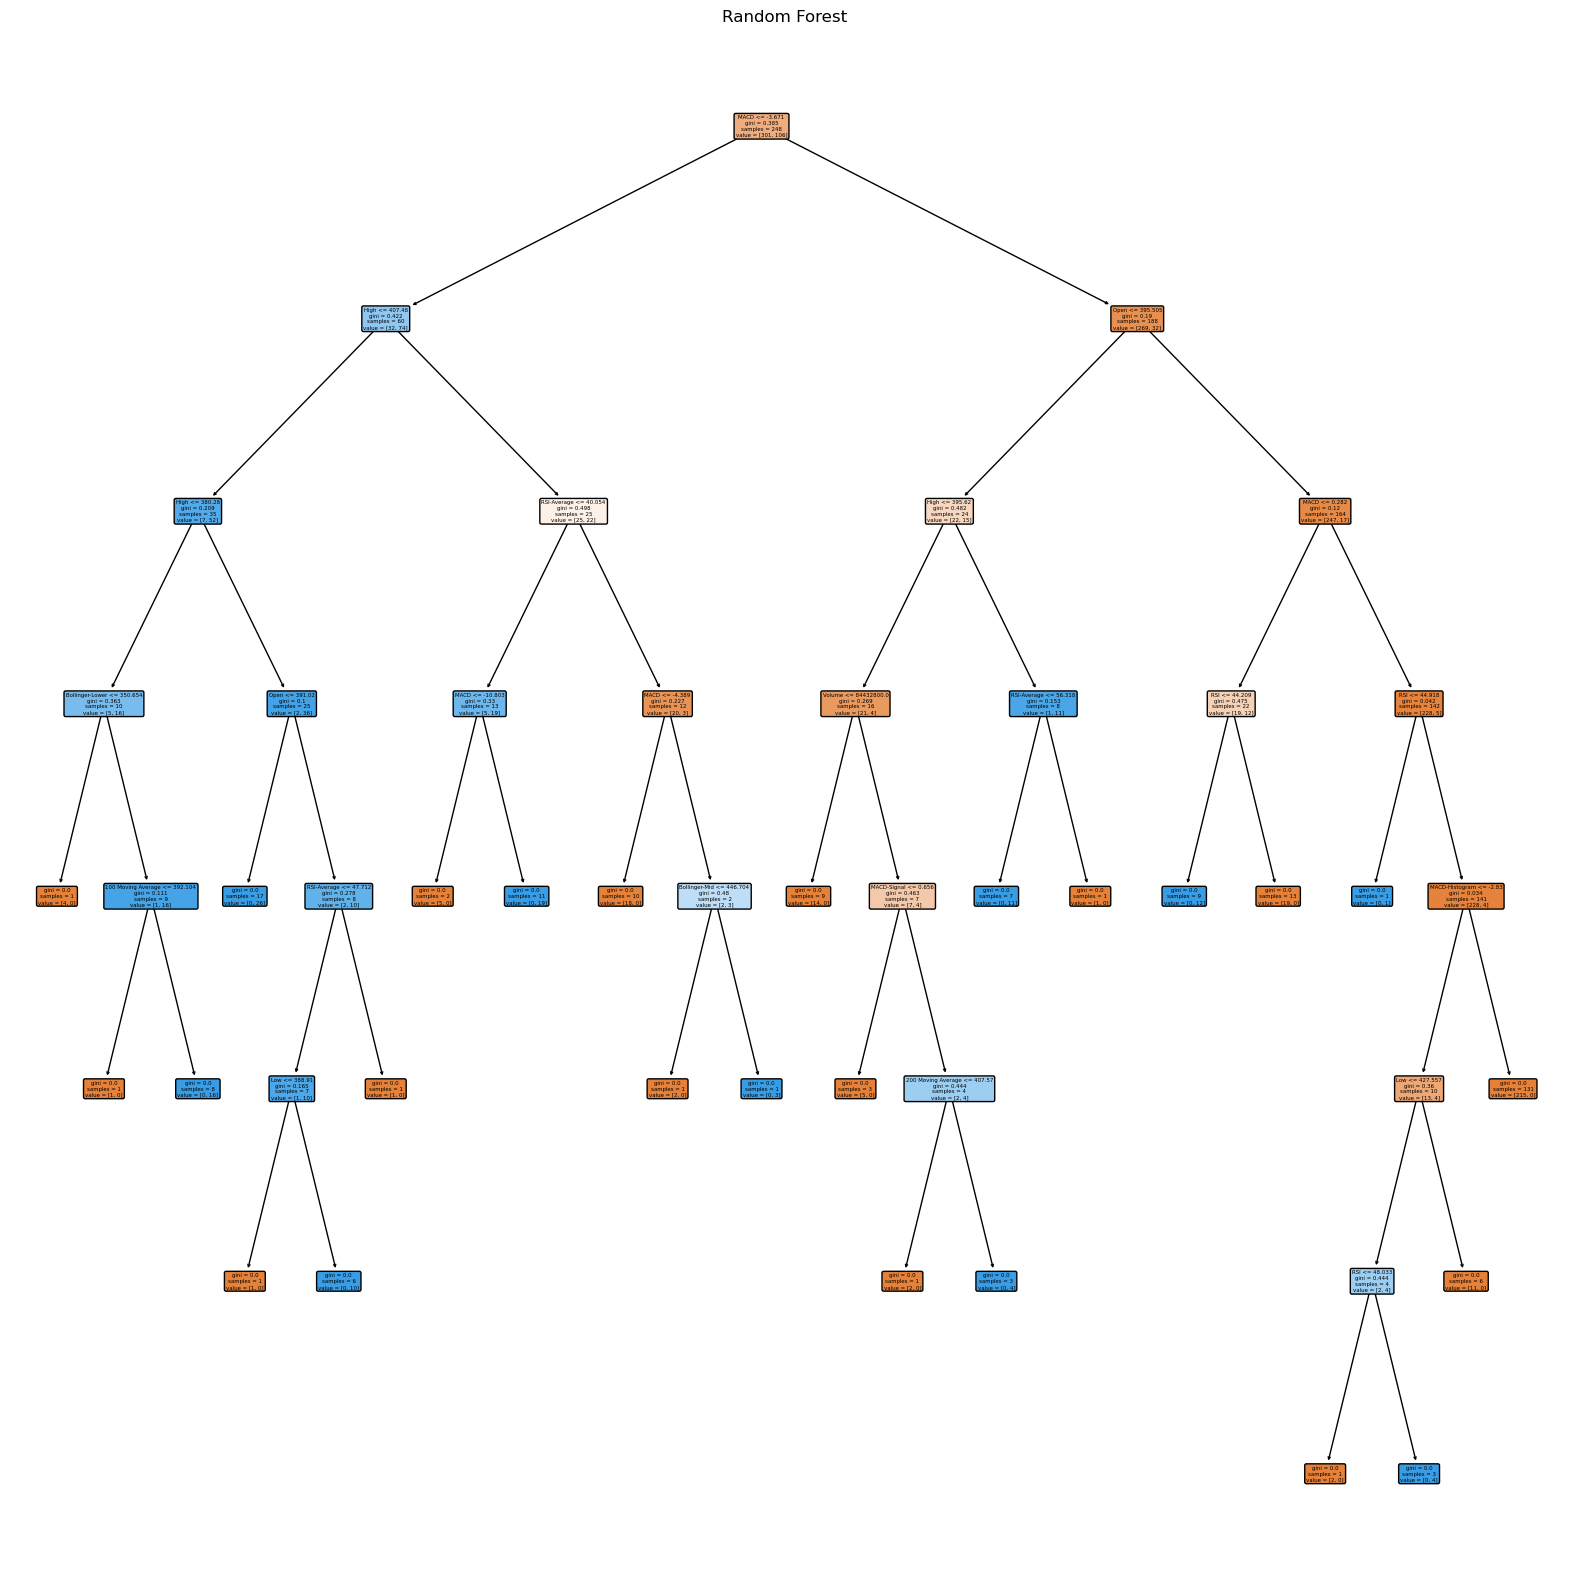

In [72]:
tree_plot(rf,X_test)

The model is to be improved using Bayesian Optimisation. A useful resource was here [https://www.kaggle.com/code/neerajmohan/randomforest-model-with-bayesian-optimization] below is an implementation from here, expanding for all hyper parameters.
The hyper parameters that will be tweaked are:-
n_estimators
Max_features
max_depth
max_sample
*criterion -- categorical input see below

This has been expanded to make use of categorical mapping components within BO. Typically by design this is not used, but by defining it as a map of values and using a category integeter rounding. For random forest we have trebled the number of possible combinations and included different key metrics in an automated fashion. Else we would end up doing BO for one category e.g. 'gini' and discounting the others.

In [13]:

# Define categorical mapping
criterion_mapping = {0: 'gini', 1: 'entropy', 2: 'log_loss'}

def stratified_kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    strat_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in strat_kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)

    return np.array(accuracy_list).mean()

def bo_params_rf(max_samples,n_estimators,max_features,max_depth,criterion):
    
    params = {
        'max_samples': max_samples,
        'max_depth': max_depth,
        'max_features':max_features,
        'n_estimators':int(n_estimators),
        'criterion': criterion
    }
    clf = RandomForestClassifier(criterion = criterion_mapping[int(round(criterion))],
                                 max_samples=params['max_samples'],
                                 max_depth=int(params['max_depth']),
                                 max_features=params['max_features'],
                                 n_estimators=params['n_estimators'])
    score = stratified_kfold_score(clf,X_train, y_train,5)
    return score

rf_bo = BayesianOptimization(bo_params_rf, {
                                            'criterion': (0,2),          #using mapping as BO does not work with categorical values
                                              'max_samples':(0.5,1),
                                                'max_features':(0.5,1),
                                              'n_estimators':(100,200),
                                                'max_depth':(10,50)
                                             })

In [14]:
#This records the time to do the optimisation

start_time =time.time()
results = rf_bo.maximize(n_iter=600, init_points=60) #Was 200,20 but with 3X the number of inputs this was trebled.
end_time = time.time()
total_time = (end_time - start_time) / 60


|   iter    |  target   | criterion | max_depth | max_fe... | max_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.941     | 0.641     | 31.73     | 0.559     | 0.7827    | 153.5     |
| 2         | 0.946     | 1.917     | 47.93     | 0.5046    | 0.9242    | 166.3     |
| 3         | 0.9361    | 0.6469    | 24.94     | 0.7937    | 0.6781    | 101.1     |
| 4         | 0.9312    | 0.2429    | 32.2      | 0.5789    | 0.5532    | 153.7     |
| 5         | 0.9361    | 1.303     | 11.08     | 0.9476    | 0.5095    | 198.3     |
| 6         | 0.9435    | 1.209     | 24.33     | 0.8775    | 0.9916    | 116.3     |
| 7         | 0.9337    | 0.4943    | 37.89     | 0.5428    | 0.5528    | 104.1     |
| 8         | 0.9263    | 0.2755    | 14.53     | 0.9928    | 0.5492    | 178.9     |
| 9         | 0.9361    | 1.011     | 44.82     | 0.5461    | 0.7074    | 135.8     |
| 10        | 0.9435    | 1.085     | 30.49     | 0.98

In [ ]:
print("Execution time took ",total_time, " mins")

In [37]:
params = rf_bo.max['params']
params['n_estimators']= int(params['n_estimators'])
params['criterion'] = criterion_mapping[int(round(params['criterion']))]
params['max_depth']=int(params['max_depth'])
print(params)

{'criterion': 'log_loss', 'max_depth': 35, 'max_features': 0.6161733644459485, 'max_samples': 0.940087494327472, 'n_estimators': 106}


We now have the ideal values to use in our Random Forest. The next step is to create an ideal forest and report
ams)
{'criterion': 'log_loss', 'max_depth': 35, 'max_features': 0.6161733644459485, 'max_samples': 0.940087494327472, 'n_estimators': 106}

In [44]:
#setup and train the random forest with ideal values
rf_ideal= RandomForestClassifier(criterion = params['criterion'],
                                 max_samples=params['max_samples'],
                                 max_depth=int(params['max_depth']),
                                 max_features=params['max_features'],
                                 n_estimators=params['n_estimators'])
rf_ideal.fit(X_train,y_train)

In [48]:
print(classification_report(y_test, rf_ideal.predict(X_test)))

              precision    recall  f1-score   support

         BUY       0.98      0.95      0.96        99
        SELL       0.88      0.95      0.91        37

    accuracy                           0.95       136
   macro avg       0.93      0.95      0.94       136
weighted avg       0.95      0.95      0.95       136



From a previous run using the defaults
              precision    recall  f1-score   support

         BUY       0.99      0.96      0.97        99
        SELL       0.90      0.97      0.94        37

    accuracy                           0.96       136
   macro avg       0.94      0.97      0.95       136
weighted avg       0.97      0.96      0.96     deleted


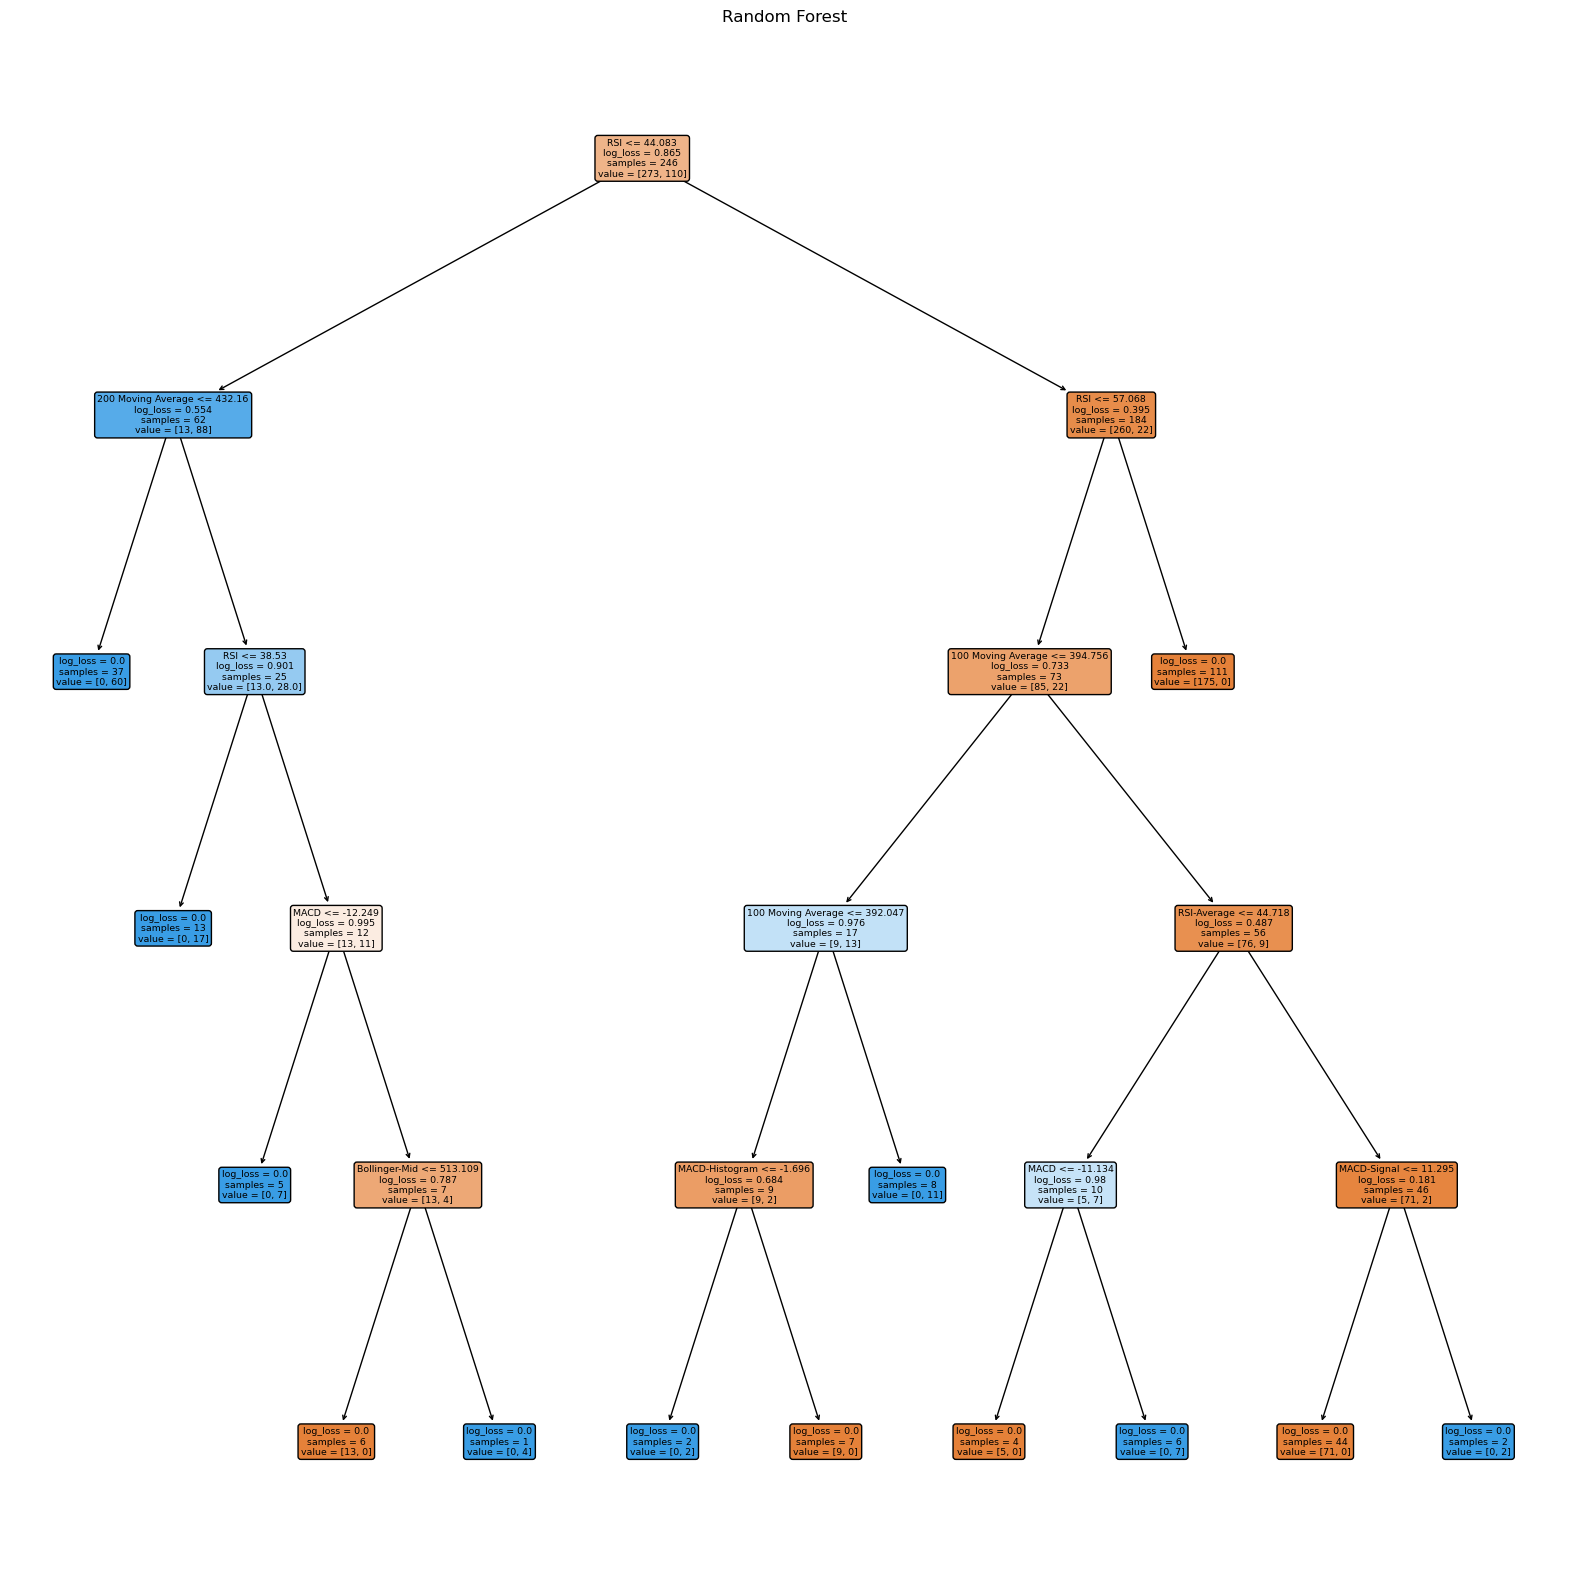

In [70]:
tree_plot(rf_ideal,X_test)

This final tree is much simplified compared to the original with defaults. Since there are less comparitors the result will be faster execution.